In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/combined_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [4]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [5]:
del feature_array, label_array

In [6]:
with np.load("root_files/combined_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [7]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [8]:
del feature_array_test, label_array_test

In [9]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [10]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 49)
(11734326, 49)
(1467277, 49)
(1467277, 49)


In [11]:
del bkg, sig, bkg_test, sig_test, df

In [12]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [13]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 49)
(1782913, 49)
(222732, 49)
(222732, 49)


  0%|          | 0/48 [00:00<?, ?it/s]

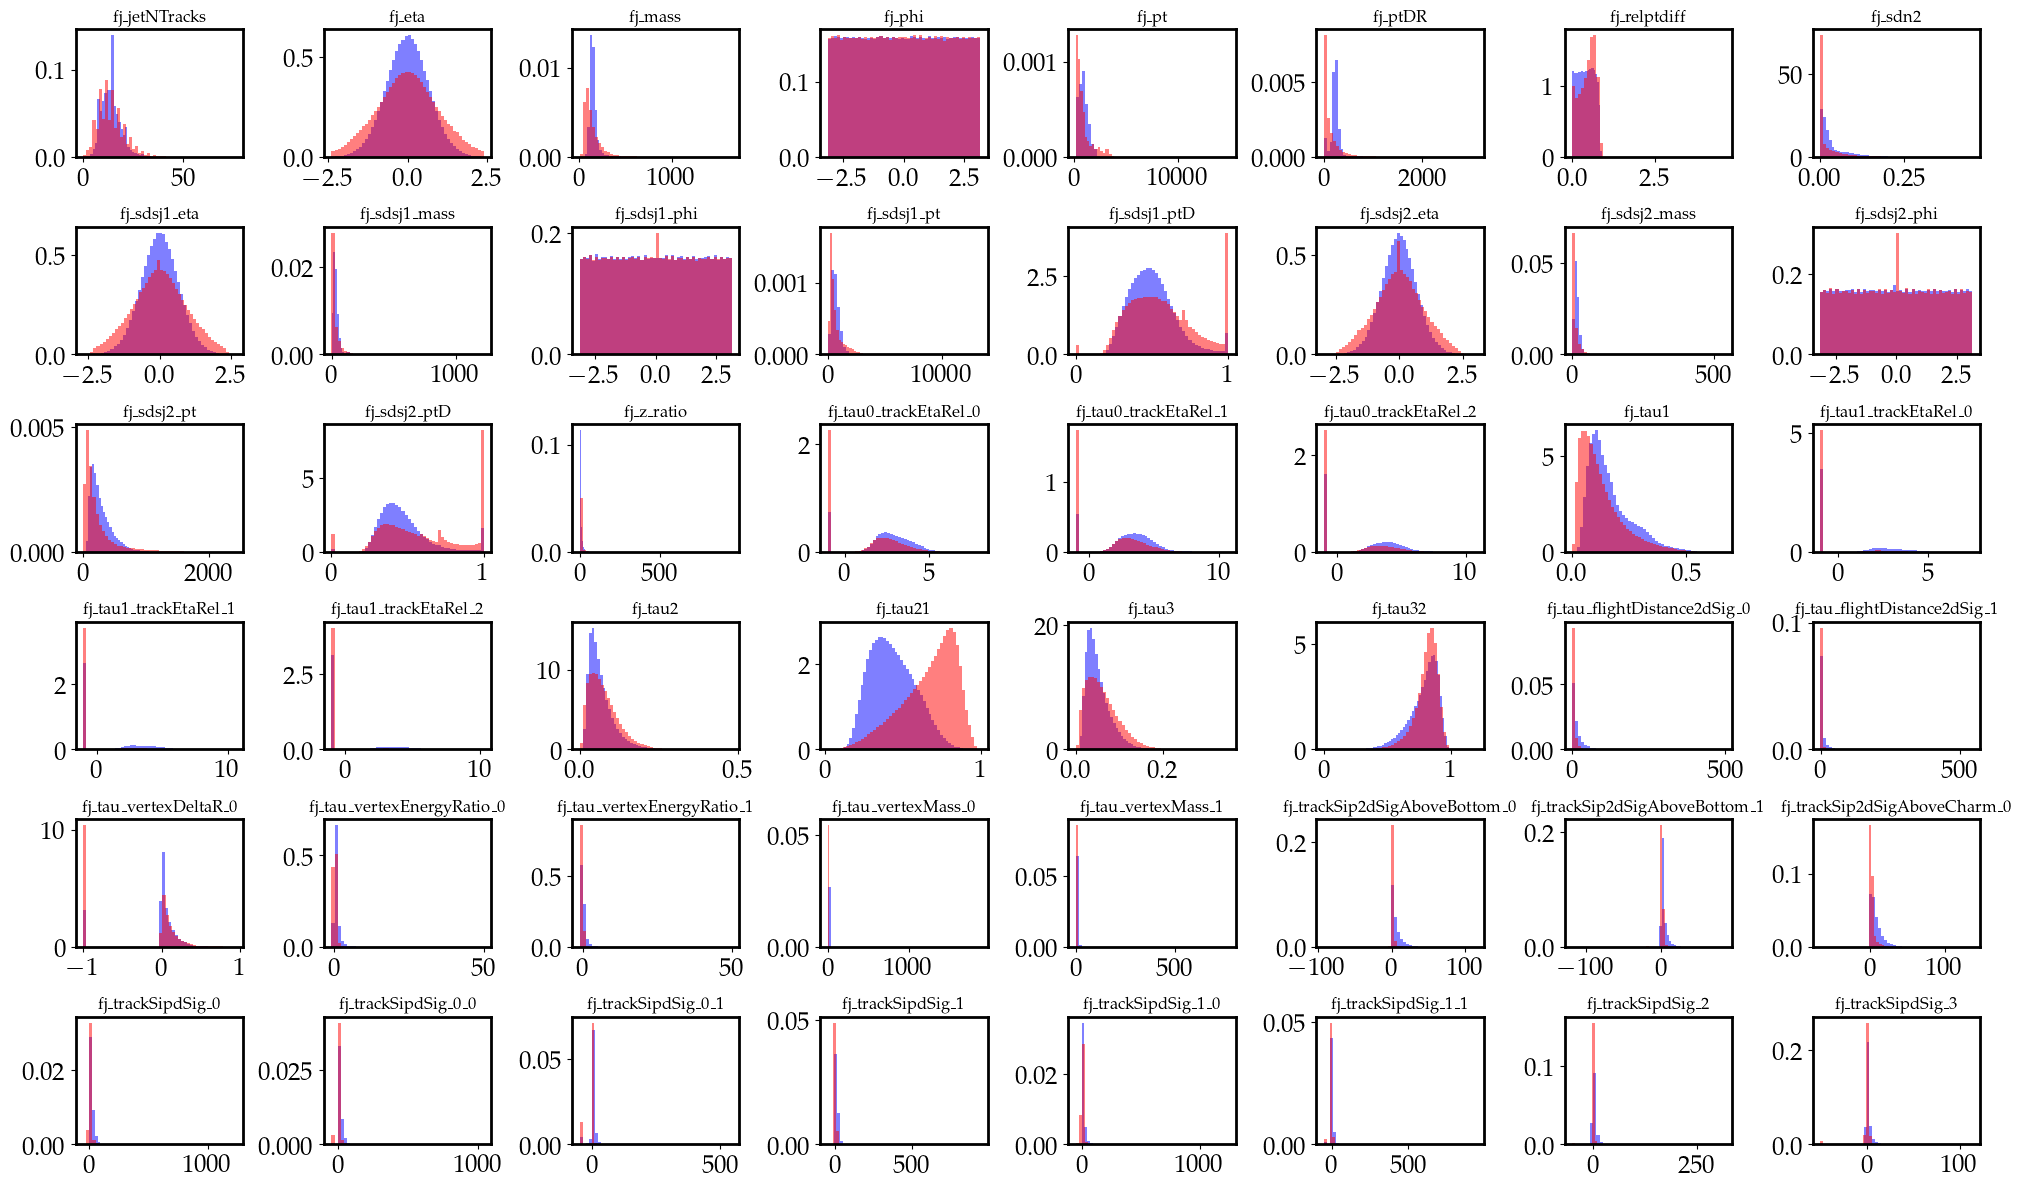

In [14]:
fig, axes = plt.subplots(6,8, figsize=(20,12))

features_to_plot = sig_train_out.columns.drop('fj_nSV')

for ax, label in tqdm(zip(axes.ravel(), features_to_plot), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('plots/hists.pdf')
plt.show()

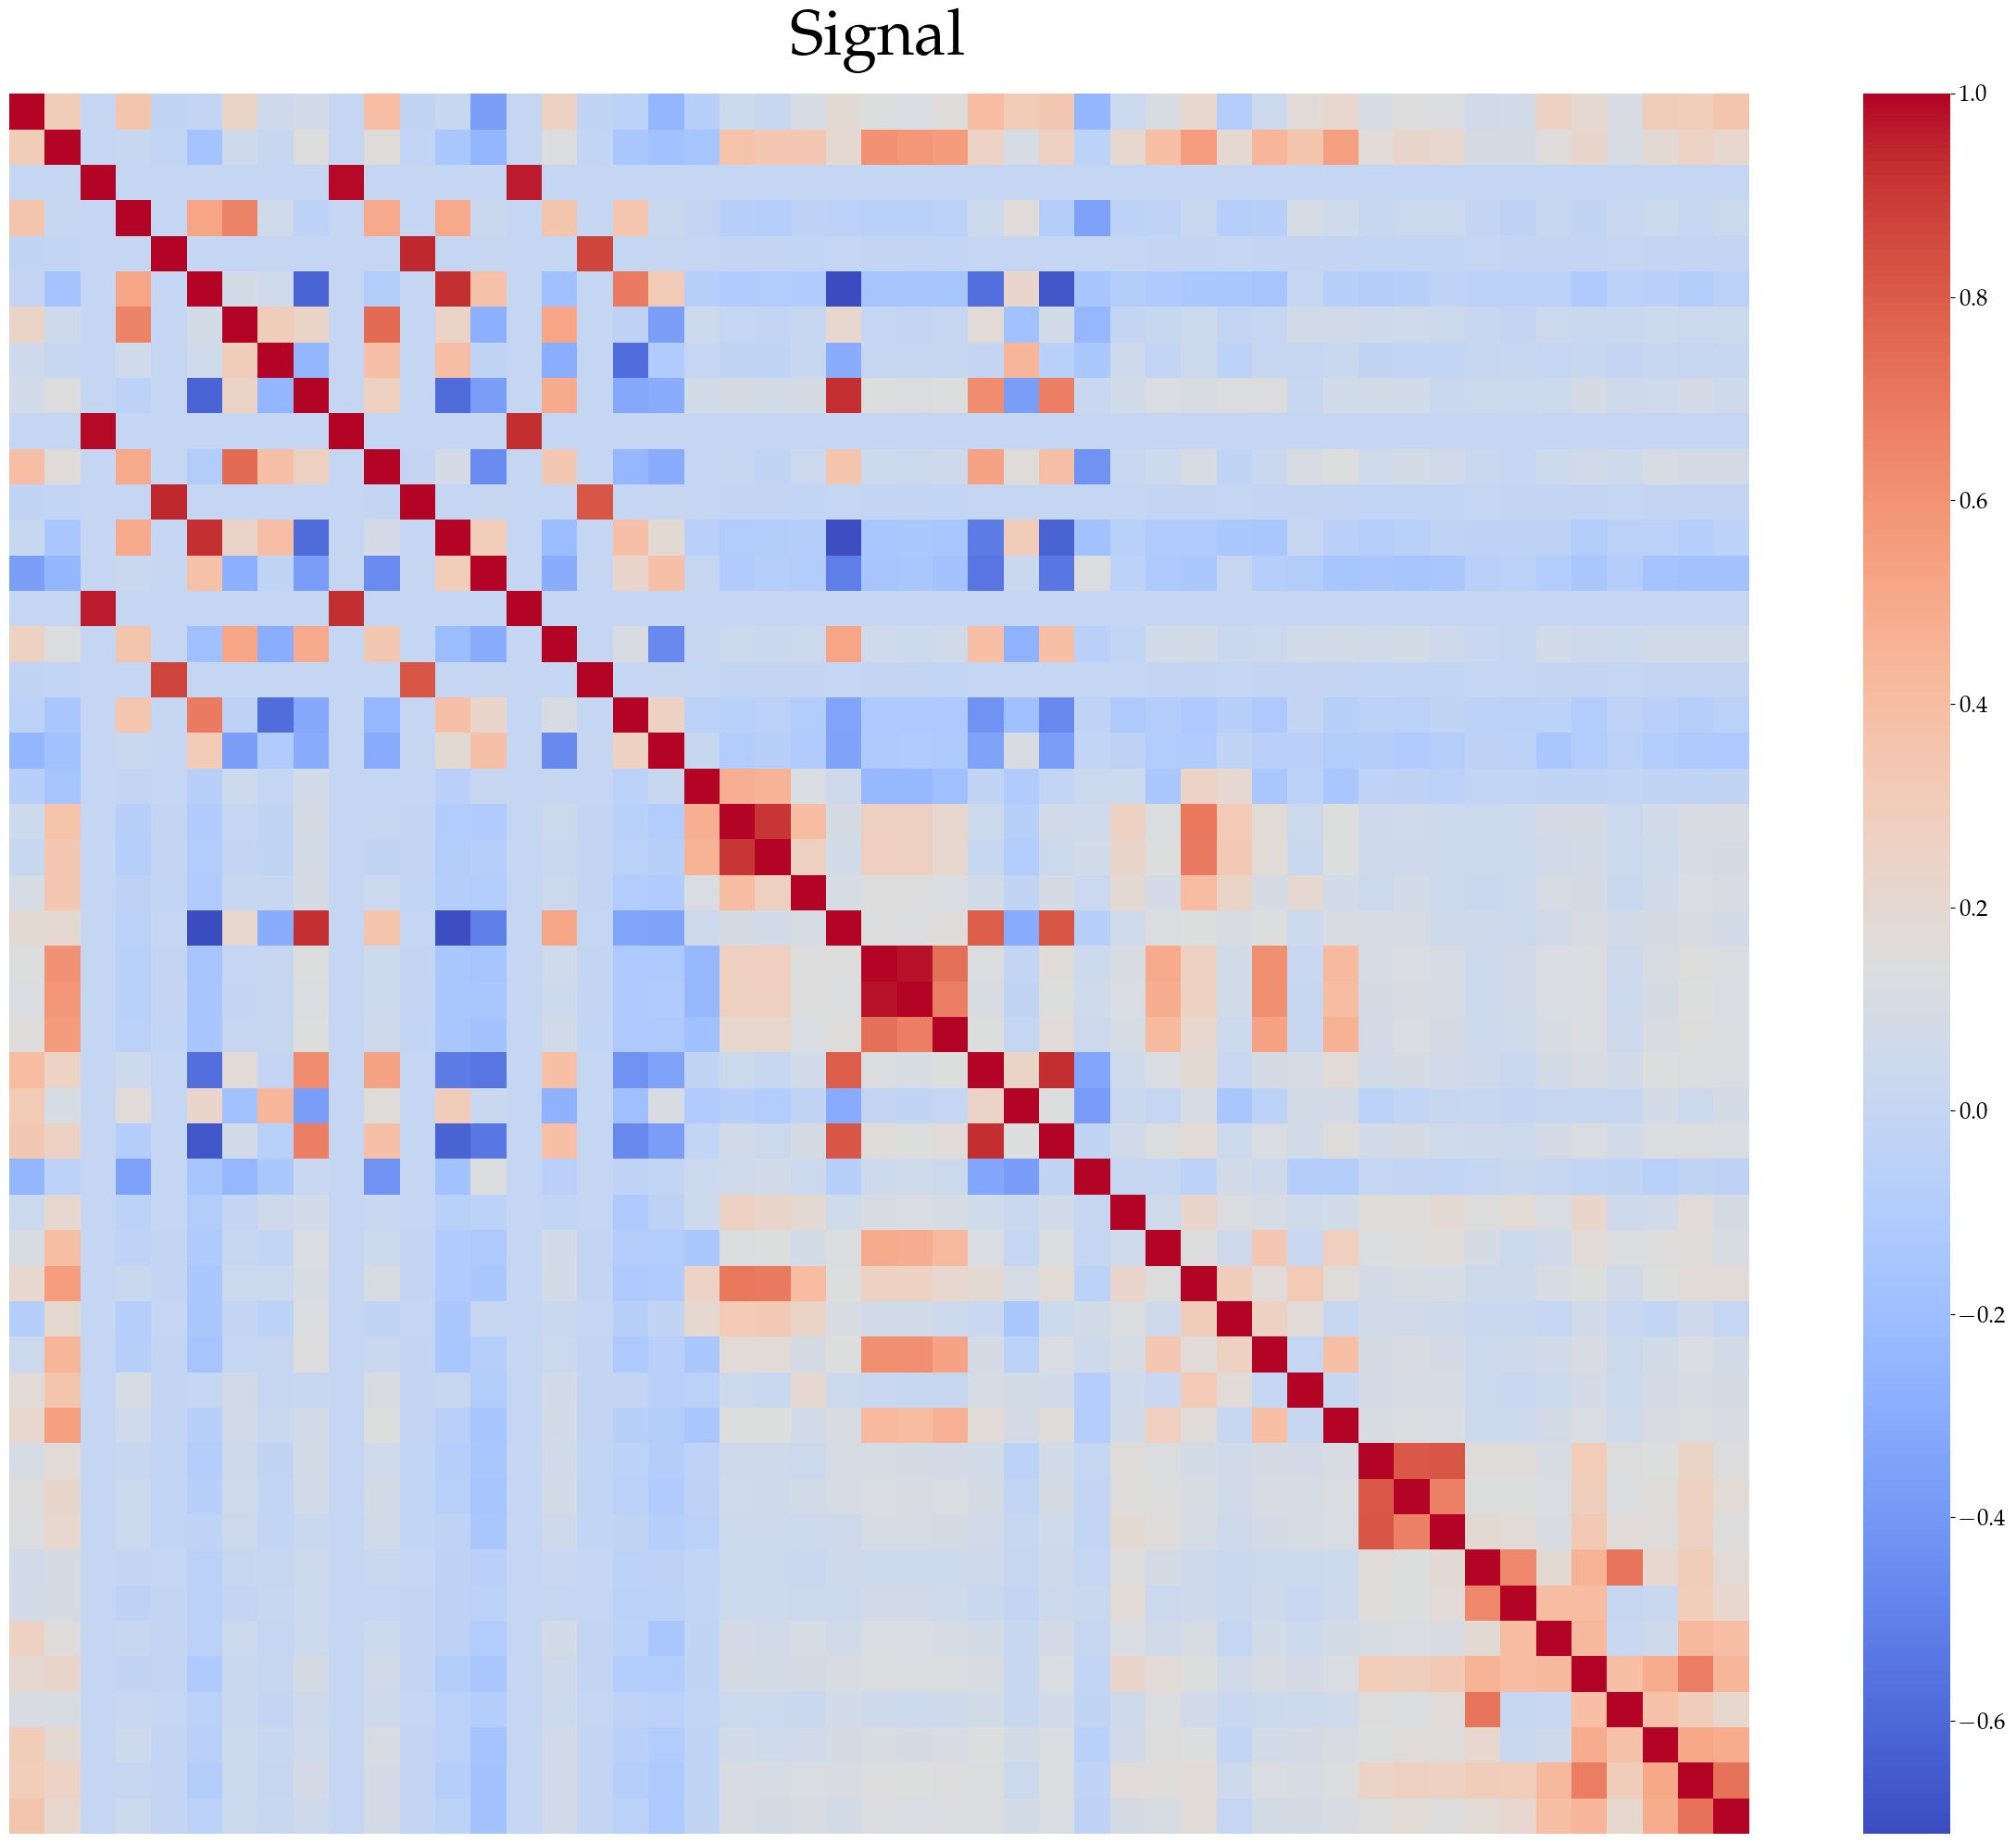

In [15]:
plt.figure(figsize=(25,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True,
            xticklabels=False, yticklabels=False)
plt.title('Signal', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_sig.pdf', bbox_inches='tight')
plt.show()

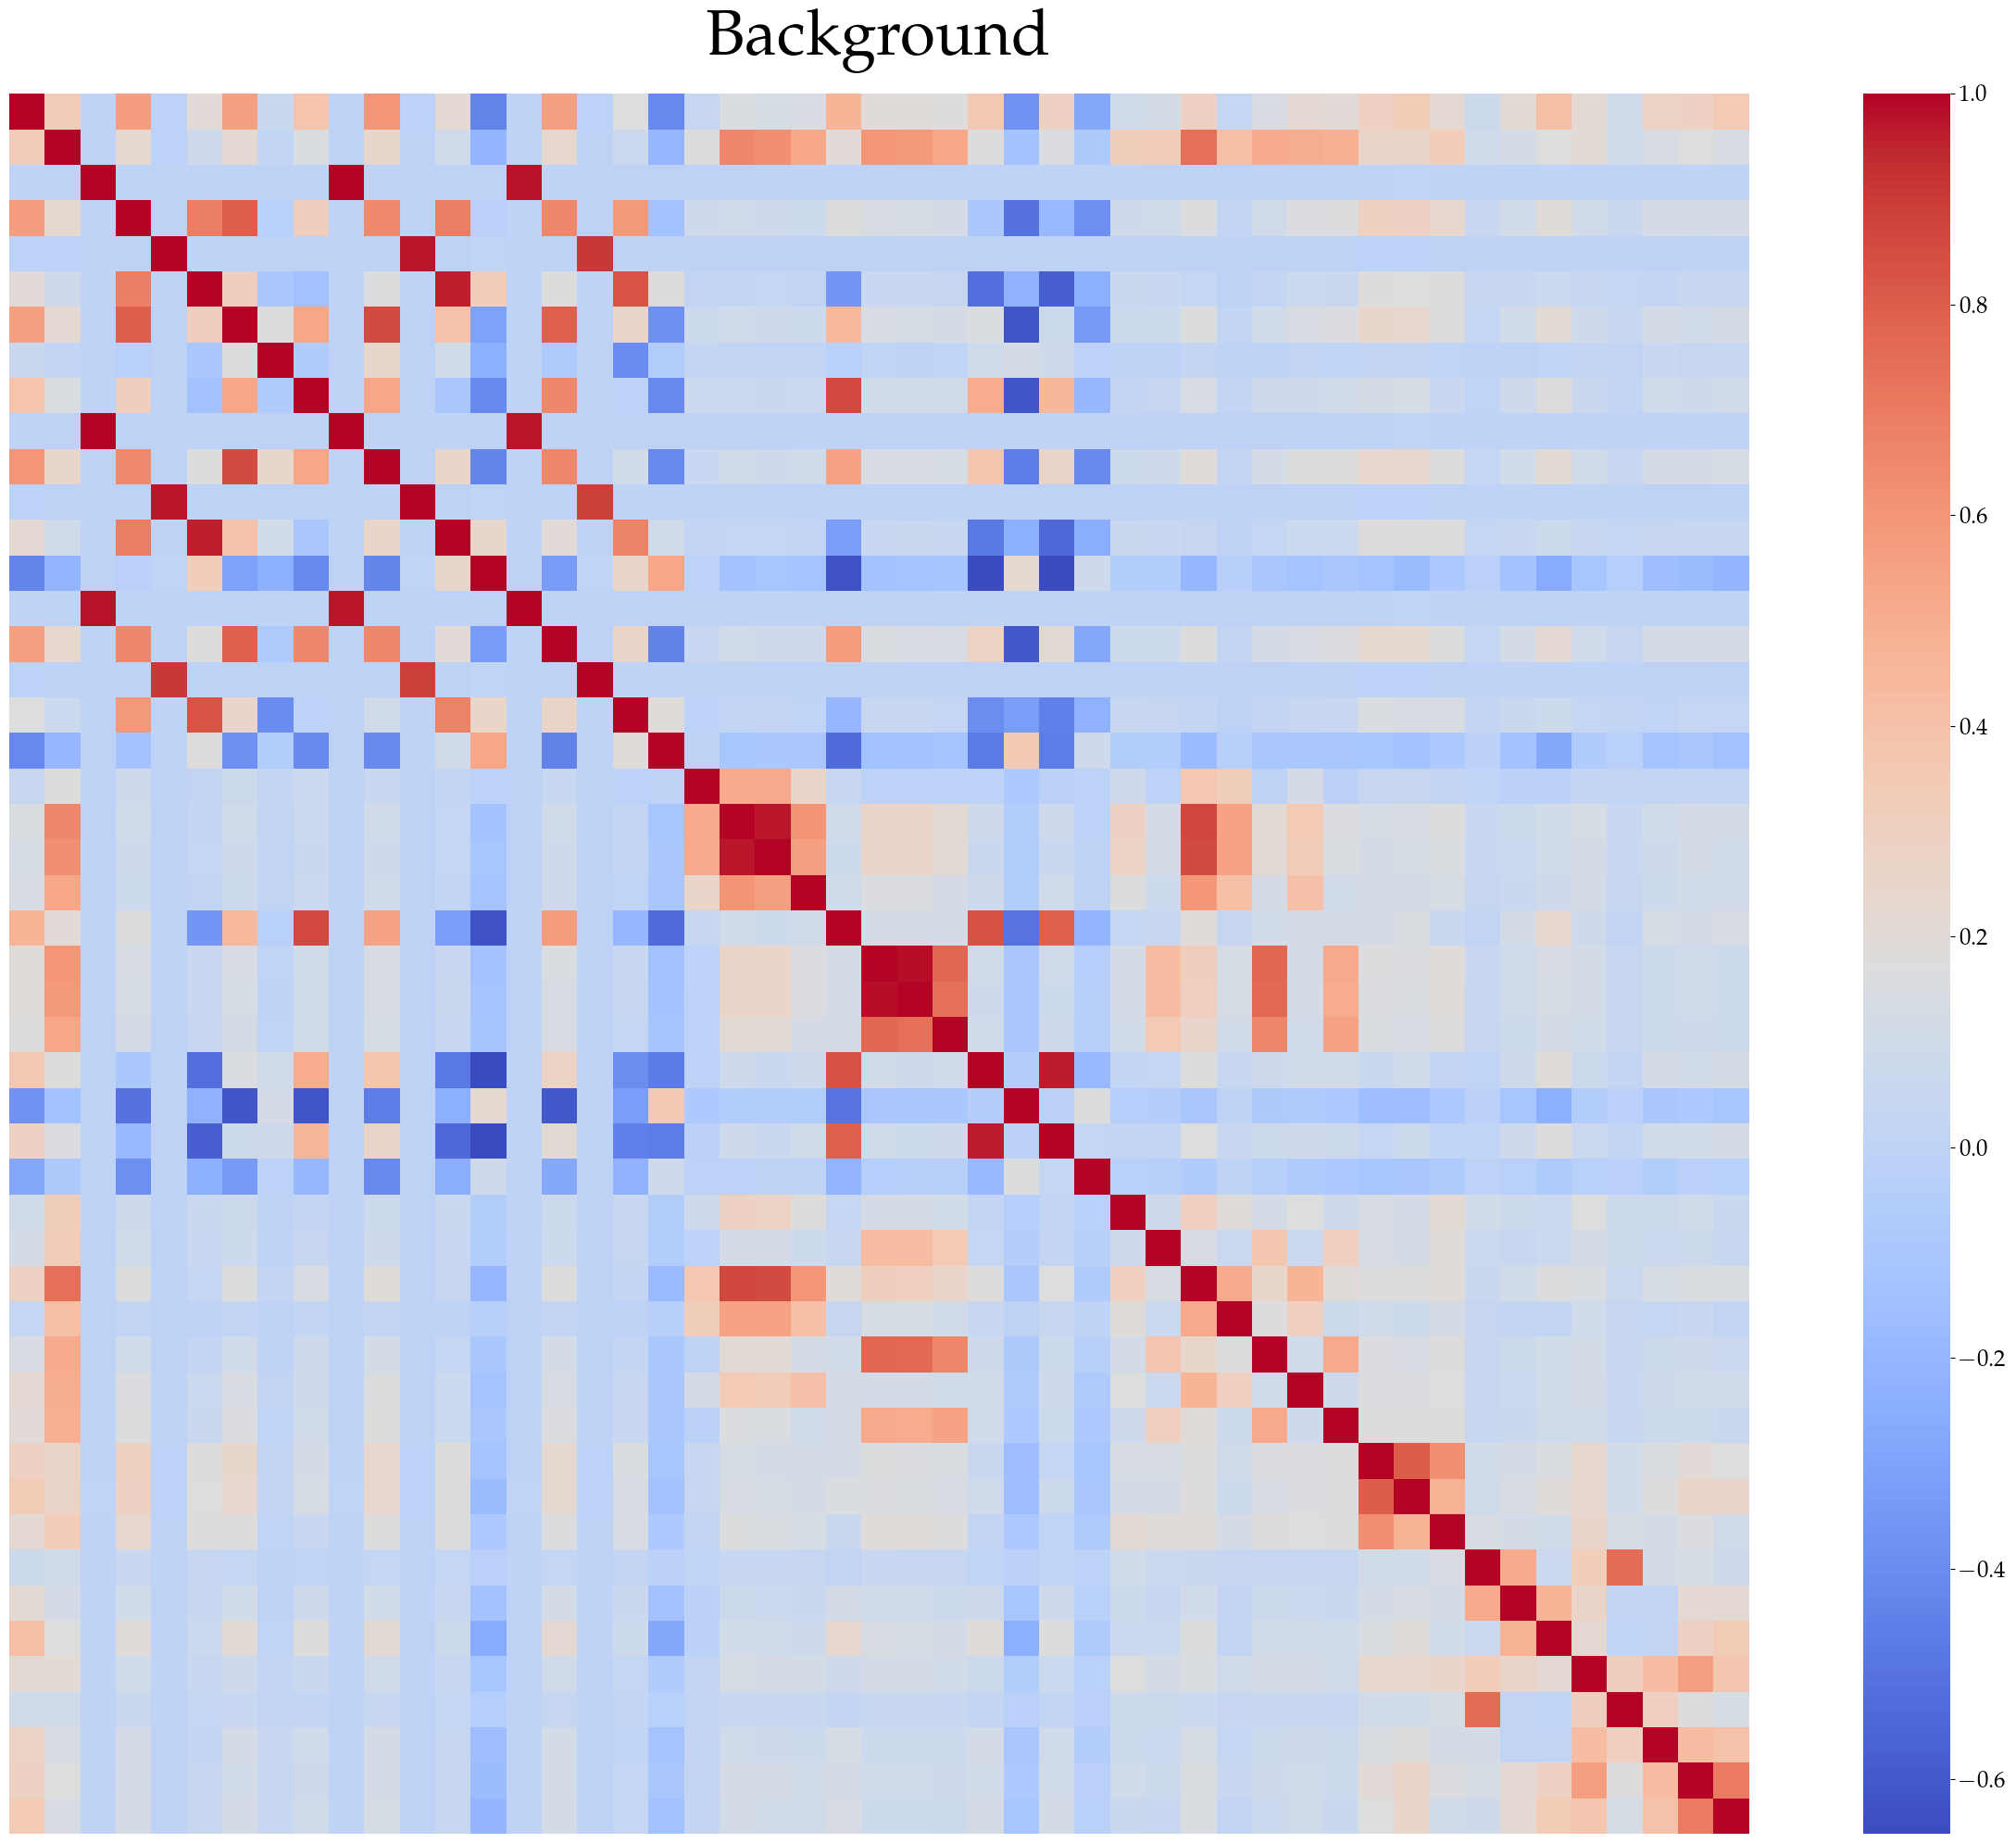

In [16]:
plt.figure(figsize=(25,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True, 
            xticklabels=False, yticklabels=False)
plt.title('Background', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_bkg.pdf', bbox_inches='tight')
plt.show()

In [17]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [18]:
del traindata

In [19]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [20]:
del testdata

In [21]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 536 ms, sys: 237 ms, total: 773 ms
Wall time: 772 ms


In [22]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [23]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

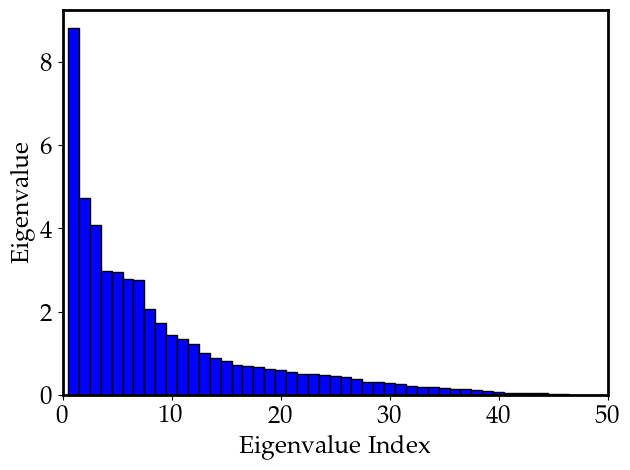

In [24]:
plt.figure()
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.tight_layout()
plt.savefig('plots/eigenvalues.pdf')
plt.show()

In [25]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[1.79691187e-01 9.67586742e-02 8.33886055e-02 6.05992067e-02
 6.01332506e-02 5.70977412e-02 5.62027130e-02 4.20882559e-02
 3.54052372e-02 2.96078935e-02 2.75088889e-02 2.48717844e-02
 2.06904050e-02 1.81932341e-02 1.64698424e-02 1.46262719e-02
 1.42651669e-02 1.36344083e-02 1.27856101e-02 1.24046277e-02
 1.14868696e-02 1.03818800e-02 1.02689686e-02 1.00322515e-02
 9.18263968e-03 8.68900811e-03 7.72612219e-03 6.41937383e-03
 6.29164738e-03 6.12386618e-03 5.42303471e-03 4.22082906e-03
 4.10847104e-03 3.77315373e-03 3.30850661e-03 3.04297144e-03
 2.76167247e-03 2.42398244e-03 2.07969584e-03 1.25158357e-03
 9.91004912e-04 9.09171333e-04 8.78172890e-04 8.20126385e-04
 3.69236941e-04 2.74699629e-04 1.94575099e-04 8.30806586e-05
 6.04001629e-05]
[0.17969119 0.27644986 0.35983847 0.42043767 0.48057092 0.53766866
 0.59387138 0.63595963 0.67136487 0.70097276 0.72848165 0.75335344
 0.77404384 0.79223708 0.80870692 0.82333319 0.83759836 0.85123277
 0.86401838 0.876423   0.88790987 0.89829175 0.908

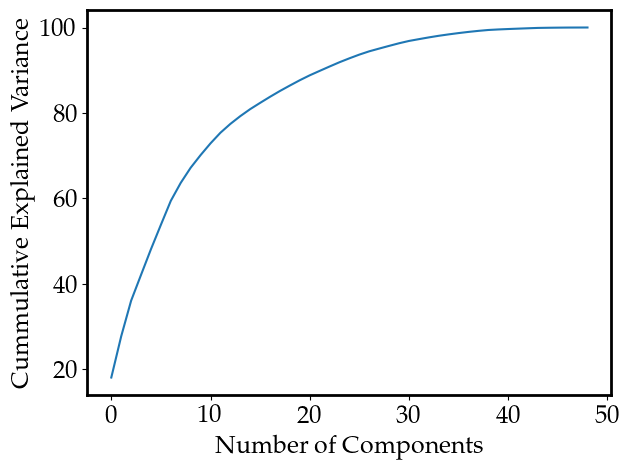

In [26]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.tight_layout()
plt.savefig('plots/pca_explained_variance.pdf')
plt.show()

In [27]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [28]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/49 [00:00<?, ?it/s]

fj_mass                          2.817308
fj_ptDR                          2.343516
fj_tau21                         2.228894
fj_trackSip2dSigAboveBottom_0    1.406772
fj_sdsj2_mass                    1.400166
fj_trackSip2dSigAboveCharm_0     1.172027
fj_sdsj1_mass                    1.156332
fj_sdsj2_pt                      1.131804
fj_sdn2                          1.076411
fj_trackSip2dSigAboveBottom_1    1.043247
fj_pt                            0.987995
fj_tau_flightDistance2dSig_0     0.930543
fj_trackSipdSig_0_0              0.858626
fj_tau_vertexEnergyRatio_0       0.756251
fj_trackSipdSig_0                0.724210
fj_nSV                           0.705436
fj_sdsj1_pt                      0.695735
fj_tau_vertexDeltaR_0            0.607151
fj_trackSipdSig_0_1              0.597691
fj_tau_vertexEnergyRatio_1       0.596316
fj_trackSipdSig_1                0.587615
fj_tau1                          0.563194
fj_sdsj2_ptD                     0.562429
fj_trackSipdSig_2                0

  0%|          | 0/6 [00:00<?, ?it/s]

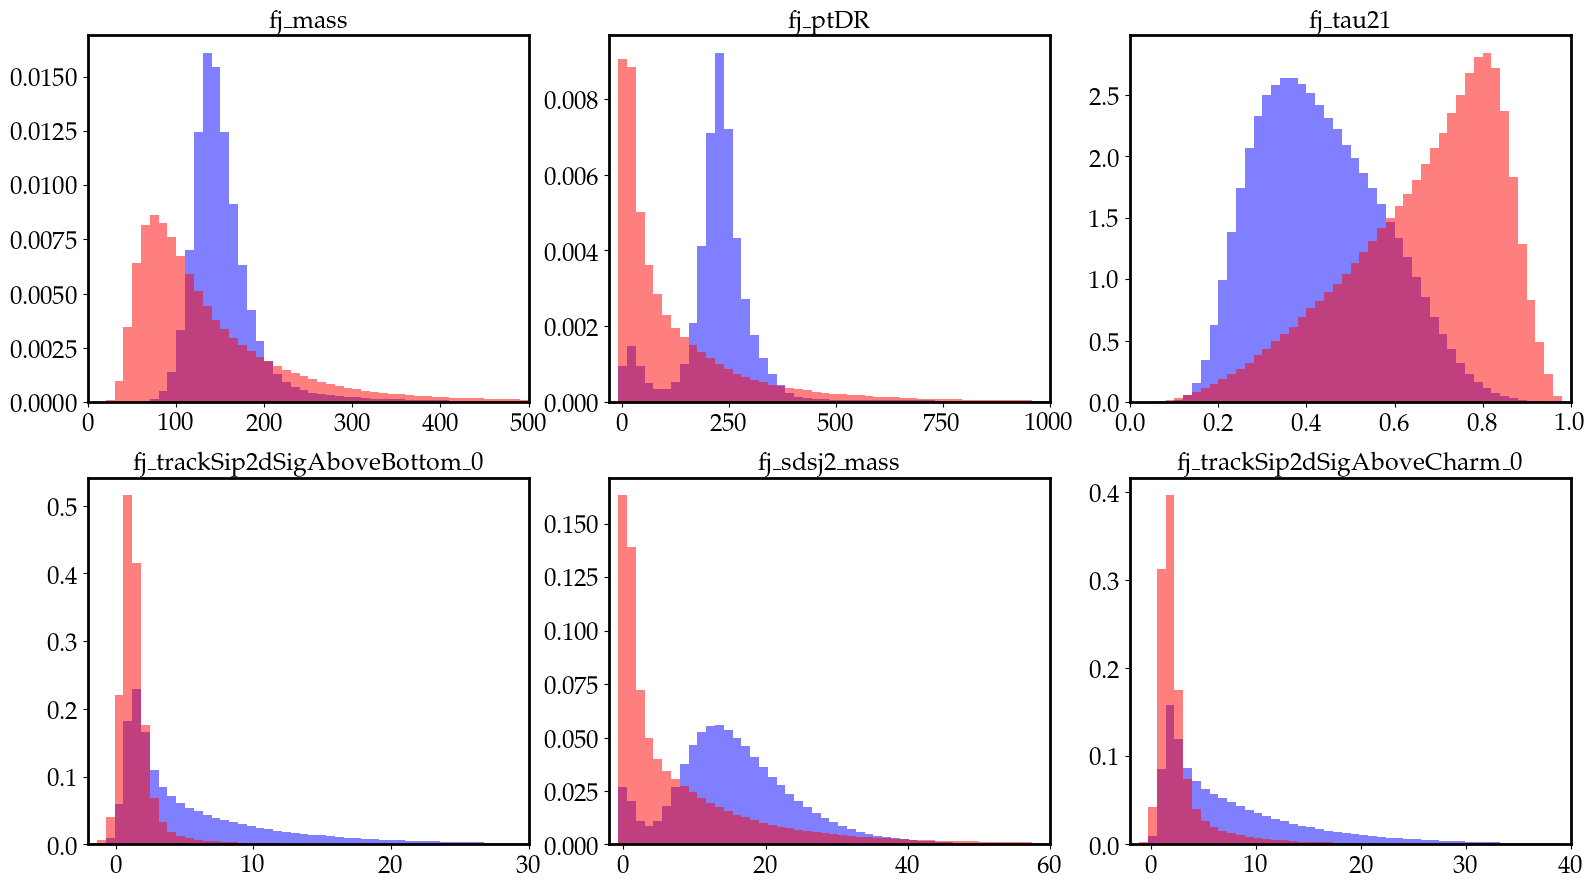

In [29]:
fig, axes = plt.subplots(2,3, figsize=(16,9))

features_to_plot = divergences.index.tolist()[:6]

lims = [(0,500),(-30,1000),(0,1),(-2,30),(-2,60),(-2,40)]

for ax, label, lim in tqdm(zip(axes.ravel(), features_to_plot, lims), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50, range=lim)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50, range=lim)
    ax.set_title(label,fontsize=18)
    ax.set_xlim(lim)
    
plt.tight_layout()
plt.savefig('plots/high_divergence_hists.pdf')
plt.show()

In [30]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [31]:
np.savez(f'root_files/train_test_{len(features)}variables.npz', 
         X_train = X_train_final, y_train = y_train, X_test = X_test_final, y_test = y_test,
         variables = features, labels = ['hbb', 'QCD'])